In [1]:
import ROOT
import numpy as np
ROOT.gStyle.SetMarkerSize(1.4)

# The commands really help with the speed as they silence the output from RooFit :)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR);
ROOT.RooMsgService.instance().setSilentMode(True);

Welcome to JupyROOT 6.17/01


## Exercise

In [2]:
fIn=ROOT.TFile.Open("inputs_session3.root")
fIn.ls()
# take the data histograms and covert them in RooDataHist.
x=ROOT.RooRealVar("x","x",110,160)
x.setBins(50)

tags=["ggH","qqH","ttH"]

th1 = [ fIn.Get("data_%s_hgg__mgg"%t) for t in tags ]
dh  = [ ROOT.RooDataHist("dh_%s"%t,"%s data distribution"%t,ROOT.RooArgList(x),h) for t,h in zip(tags,th1)]
cat = ROOT.RooCategory("cat","cat")
[ cat.defineType(t) for t in tags ]

# Create the combined data set with 3 categories 
combData = ROOT.RooDataHist("combData","combData", ROOT.RooArgList(x),
                            ROOT.RooFit.Index(cat),
                            ROOT.RooFit.Import("ggH",dh[0]),
                            ROOT.RooFit.Import("qqH",dh[1]),
                            ROOT.RooFit.Import("ttH",dh[2])
                           )

TFile**		inputs_session3.root	
 TFile*		inputs_session3.root	
  KEY: TH1F	data_ggH_hgg__mgg;1	Histogram of data_ggH_hgg__mgg
  KEY: TH1F	data_qqH_hgg__mgg;1	Histogram of data_qqH_hgg__mgg
  KEY: TH1F	data_ttH_hgg__mgg;1	Histogram of data_ttH_hgg__mgg
  KEY: TH2D	Response;1	sig


In [3]:
##############################################
#            BACKGROUND MODEL                #
##############################################

par_b = [ROOT.RooRealVar("exp_1_%s"%t,"exp_parameter_%s"%t,-0.2,-1, -0.01) for t in tags ]
models_b = [ ROOT.RooExponential("b_%s"%t,"b_%s"%t,x,b) for t,b in zip(tags,par_b) ]
n_bkg =[ROOT.RooRealVar("nbkg_%s"%t,"nbkg_%s"%t,h.Integral(), .5*h.Integral(),2.0*h.Integral()) for t,h in zip(tags,th1)]

##############################################
#            SIGNAL MODEL                    #
##############################################
# construct signal model for each tags
th2_resp=fIn.Get("Response") ## x= truth, y= reco

## for simplicity the mean and sigma of the gaussians are all identical
mean=ROOT.RooRealVar("mean","mean",125)
sigma=ROOT.RooRealVar("sigma","sigma",1.5) 
smodel=ROOT.RooGaussian("s_model_generic","smodel",x,mean,sigma) # can be different for each entry in the response matrix.

In each category (reconstuction tag), all 3 signals are present (3 production modes), but with different composition - This composition is given by the response matrix. Lets take a look at the response matrix - each entry tells me how many signal events of production "x" are expected in the category "y".


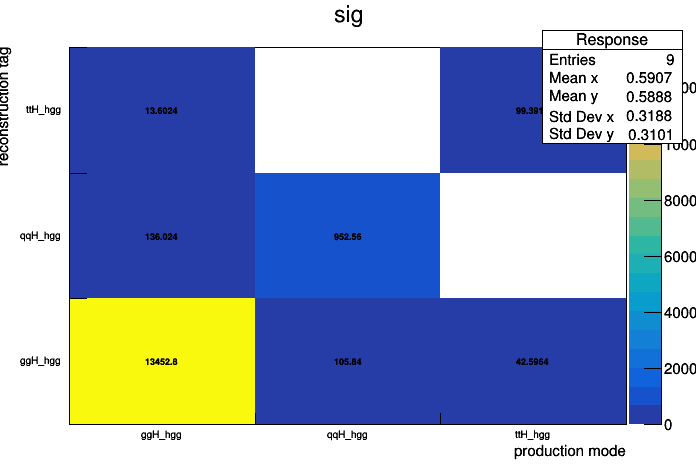

In [4]:
crsp = ROOT.TCanvas()
th2_resp.Draw("COLZ Text")
crsp.Draw()

We need to make functions which scale these expected yields by our parameters of interest (signal strengths). 

In [5]:
## construct strength modifiers for the truth components
r =[ROOT.RooRealVar("r_%s"%t,"r_%s"%t,1, 0.,5.0) for t in tags]
e =[ [ ROOT.RooRealVar("e_%s_cat%s"%(truth,tag),"",th2_resp.GetBinContent(ix+1,iy+1) ) 
      for ix,truth in enumerate(tags) ] for iy,tag in enumerate(tags) ] 
scaling = [ [ ROOT.RooFormulaVar("scaling_%s_cat%s"%(truth,tag),"@0*@1",ROOT.RooArgList(e[iy][ix],r[ix])) 
             for ix,truth in enumerate(tags) ] for iy,tag in enumerate(tags)  ]

In [6]:
##############################################
#            PER CAT MODEL                   #
##############################################
model_s = [
    ROOT.RooAddPdf("model_s_%s"%t,"",
                   ROOT.RooArgList(smodel,smodel,smodel,models_b[iy]),
                   ROOT.RooArgList(scaling[iy][0],scaling[iy][1],scaling[iy][2],n_bkg[iy])
                  )  
    for iy,t in enumerate(tags)
]

In [7]:
# Construct the simultaneous model
simPdf=ROOT.RooSimultaneous("simPdf","simultaneous pdf",cat) ;
[ simPdf.addPdf(model_s[iy],t) for iy,t in enumerate(tags)]

##############################################
#            FIT STRENGTH                    #
##############################################
fr=simPdf.fitTo(combData,ROOT.RooFit.Save(),ROOT.RooFit.Minos())


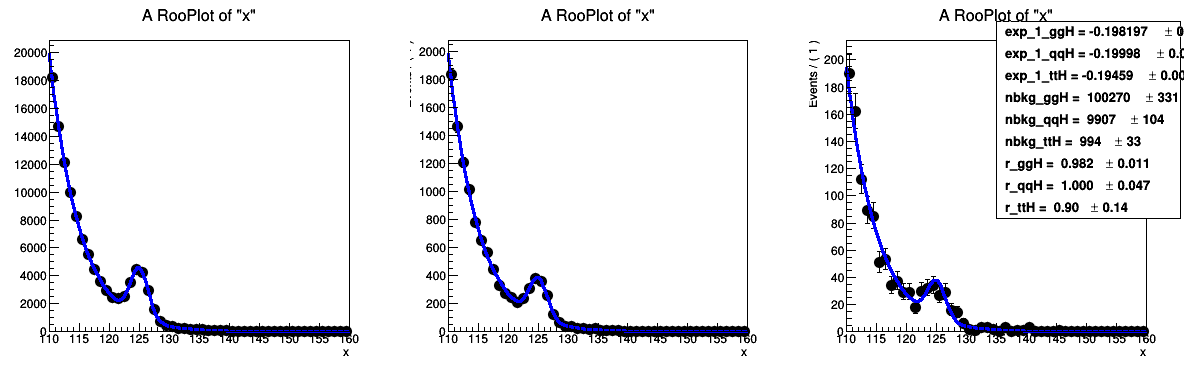

In [8]:
##############################################
#           PLOT THE FIT                     #
##############################################

plot_1 = x.frame()
plot_2 = x.frame()
plot_3 = x.frame()

c=ROOT.TCanvas("c_fits","c_fits",1200,400)
c.Divide(3)

c.cd(1)
combData.plotOn(plot_1,ROOT.RooFit.Cut("cat==cat::ggH"))
simPdf.plotOn(plot_1,ROOT.RooFit.Slice(cat,"ggH"),ROOT.RooFit.ProjWData(combData))
plot_1.Draw()

c.cd(2)
combData.plotOn(plot_2,ROOT.RooFit.Cut("cat==cat::qqH"))
simPdf.plotOn(plot_2,ROOT.RooFit.Slice(cat,"qqH"),ROOT.RooFit.ProjWData(combData))
plot_2.Draw()

c.cd(3)
combData.plotOn(plot_3,ROOT.RooFit.Cut("cat==cat::ttH"))
simPdf.plotOn(plot_3,ROOT.RooFit.Slice(cat,"ttH"),ROOT.RooFit.ProjWData(combData))
simPdf.paramOn(plot_3)
plot_3.Draw()

c.Draw()

We can convert these strengths into cross-sections if we know the reference cross-sections - In our case, the reference was SM Higgs production in pp collisions at 13 TeV. For each strength,  r = xsec/reference xsec 


In [9]:
input_cross_sections=[ 48.58, 3.78, 0.5071 ]
print 'strengths:'
print "\n".join(["%s: %f +/- (%f,%f) -> %f"%(ri.GetName(),ri.getVal(),ri.getAsymErrorLo(),ri.getAsymErrorHi(), ri.getVal()*xs) 
                 for ri,xs in zip(r,input_cross_sections)
                ])

strengths:
r_ggH: 0.981747 +/- (-0.011194,0.011270) -> 47.693288
r_qqH: 1.000471 +/- (-0.046289,0.046872) -> 3.781781
r_ttH: 0.902884 +/- (-0.141690,0.148022) -> 0.457853


We can also take a look at the correlation between these measurements.

In [10]:
#and the covariance matrix:
cor = ROOT.TH2D("cov-matrix","cor-matrix",3,0,3,3,0,3)

[ [ cor.SetBinContent(ix+1,iy+1, fr.correlation(r[ix],r[iy])) for ix,truth in enumerate(tags) ] for iy,truth2 in enumerate(tags)  ]
[ [ (cor.GetXaxis().SetBinLabel(ix+1,truth), cor.GetYaxis().SetBinLabel(iy+1,truth2)) for ix,truth in enumerate(tags) ] for iy,truth2 in enumerate(tags)  ]

cor.Print()

TH1.Print Name  = cov-matrix, Entries= 9, Total sum= 2.76734


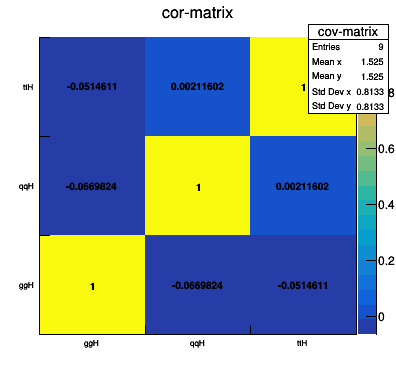

In [11]:
c=ROOT.TCanvas("cov","Correlation Matrix",400,400)
cor.Draw("COLZ Text")
c.Draw()

## Part 2: EFT fit

In this part, we are going to extract the values of the EFT coefficients which best match our data. We are using the SILH basis, and will be interested in 2 parameters $c_{G}$ and the linear combination $c_{HW}-c_{B}$. We assume all other EFT coefficients are 0, including $c_{HW}+c_{B}$.

Now we know the scaling should be 

$ r_{ggH} = 1+8.73c'_{G} + 19.5 (c'_{G})^{2} $ 

$ r_{qqH} = 1+0.6c_{B}-0.797c_{HW}+3.42c_{B}^{2}+114c_{HW}^{2}+15.3c_{HW}c_{B}$

$ r_{ttH} = 1+0.115c'_{G} +c^{2}_{B}+5.87c_{HW}^{2}+0.0297(c'_{G})^{2}-0.318c_{B}c_{HW}$ 

We can re-arrange them to 

$ r_{ggH} = 1+8.73c'_{G} + 19.5 (c'_{G})^{2} $ 

$ r_{qqH} = 1 -0.6985(c_{HW}-c_{B})+25.53(c_{HW}-c_{B})^{2}$

$r_{ttH}  = 1. + (0.115+0.0297c'_{G})c'_{G}+1.797(c_{HW}-c_{B})^2 $

In [12]:
eft=[ROOT.RooRealVar("cG1","cG1",0.,-20,20),ROOT.RooRealVar("cHWmB","cHWmB",0.,-20,20) ]
eft_scaling_function = [ # if eft =0 --> SM. ggH, qqH, ttH
     ROOT.RooFormulaVar("ggH_scaling","1. + cG1*(8.73+19.5*cG1)",ROOT.RooArgList(eft[0]) ),
     ROOT.RooFormulaVar("qqH_scaling","1. + 25.53 * cHWmB *cHWmB +cHWmB*(-0.6985)", ROOT.RooArgList(eft[0],eft[1]) ),
     ROOT.RooFormulaVar("ttH_scaling","1. + (0.115+0.0297*cG1)*cG1+1.797*cHWmB*cHWmB",ROOT.RooArgList(eft[0],eft[1]) ),
    ]
# e =[ [ ROOT.RooRealVar("e_%s_cat%s"%(truth,tag),"",th2_resp.GetBinContent(ix+1,iy+1) ) 
#  for ix,truth in enumerate(tags) ] for iy,tag in enumerate(tags) ] 
eft_scaling = [ [
    ROOT.RooFormulaVar("y_%s_cat%s"%(truth,tag),"@0*@1",ROOT.RooArgList(e[iy][ix],eft_scaling_function[ix]))
    for ix,truth in enumerate(tags) ] for iy,tag in enumerate(tags) 
]

model_eft = [
    ROOT.RooAddPdf("model_s_%s"%t,"",
                   ROOT.RooArgList(smodel,smodel,smodel,models_b[iy]),
                   ROOT.RooArgList(eft_scaling[iy][0],eft_scaling[iy][1],eft_scaling[iy][2],n_bkg[iy])
                  )  
    for iy,t in enumerate(tags)
]


As before, we create a simultaneous pdf across the 3 categories, and fit to the data. 

In [13]:
# Construct the simultaneous model
eftPdf=ROOT.RooSimultaneous("eftPdf","simultaneous pdf",cat) ;
[ eftPdf.addPdf(model_eft[iy],t) for iy,t in enumerate(tags)]

##############################################
#            FIT STRENGTH                    #
##############################################
fr=eftPdf.fitTo(combData,ROOT.RooFit.Save(),ROOT.RooFit.Minos())


 FUNCTION MUST BE MINIMIZED BEFORE CALLING MINOs     
 FUNCTION MUST BE MINIMIZED BEFORE CALLING MINOs     


Let's also plot the 2D -ve log-likelihood too. 

strengths:
cG1: -0.002140 +/- (0.000000,0.000000)
cHW-cB: 0.004434 +/- (-0.031411,0.058284)


Warning in <TFile::Append>: Replacing existing TH1: cov-matrix (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cov


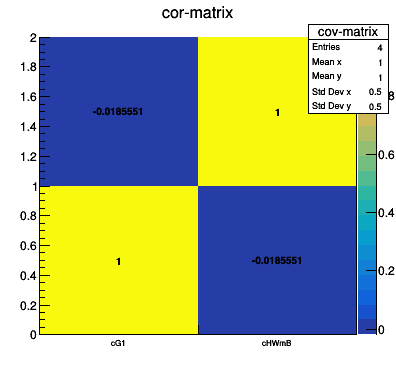

In [14]:
## eft boundaries
print 'strengths:'
print "\n".join(["%s: %f +/- (%f,%f)"%(n,ri.getVal(),ri.getAsymErrorLo(),ri.getAsymErrorHi()) 
                for n,ri in zip(["cG1","cHW-cB"],eft)
                ])

params=["cG1","cHWmB"]
#and the covariance matrix:
cor2 = ROOT.TH2D("cov-matrix","cor-matrix",2,0,2,2,0,2)
[ [ cor2.SetBinContent(ix+1,iy+1, fr.correlation(p1,p2)) for ix,p1 in enumerate(params) ] for iy,p2 in enumerate(params)  ]
[ [ (cor2.GetXaxis().SetBinLabel(ix+1,p1), cor.GetYaxis().SetBinLabel(iy+1,p2)) for ix,p1 in enumerate(params) ] for iy,p2 in enumerate(params)  ]
c=ROOT.TCanvas("cov","Correlation Matrix",400,400)
cor2.Draw("COLZ Text")
c.Draw()

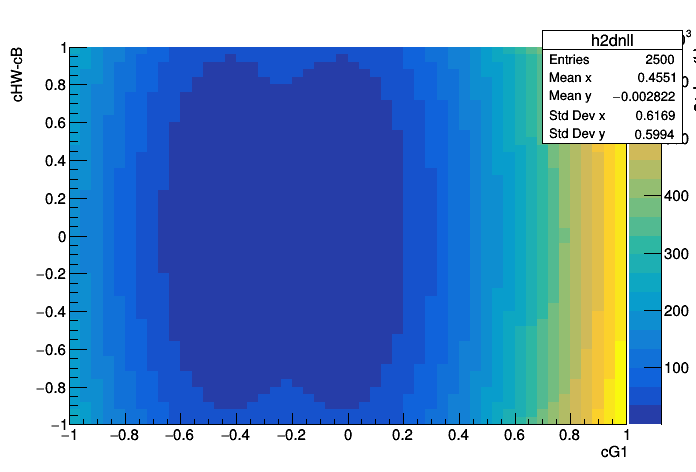

In [15]:
nll2minimum = 2*fr.minNll()

nll = eftPdf.createNLL(combData)

h2dnll = ROOT.TH2F("h2dnll",";cG1;cHW-cB;-2#Delta Log(L)",50,-1,1,50,-1,1)

for ix in range(h2dnll.GetNbinsX()): 
    eft[0].setVal(h2dnll.GetXaxis().GetBinCenter(ix+1)) # TH1/TH2 bins start at 1
    for iy in range(h2dnll.GetNbinsY()): 
        eft[1].setVal(h2dnll.GetYaxis().GetBinCenter(iy+1))
        h2dnll.SetBinContent(ix+1,iy+1,2*nll.getVal()-nll2minimum)
    
c2d = ROOT.TCanvas()
h2dnll.Draw("COLZ")
c2d.Draw()


In [16]:
# 1D LH scan for cG1
eft[0].setConstant(True);
gr_cG1 = ROOT.TGraph(); 

minim = ROOT.RooMinimizer(nll);
for ix,gr_cG1_v in enumerate(np.arange(-1,1,0.1)):
    eft[0].setVal(gr_cG1_v)
    minim.minimize("Minuit","migrad");
    gr_cG1.SetPoint(ix,gr_cG1_v,2*nll.getVal()-nll2minimum)    

eft[0].setConstant(False);
eft[1].setVal(0) # back to close to minimum 
eft[0].setVal(0);

# 1D LH scan for cHW-cB
eft[1].setConstant(True);
gr_cHWmB = ROOT.TGraph(); 

minim = ROOT.RooMinimizer(nll);
for ix,gr_cHWmB_v in enumerate(np.arange(-1,1,0.1)):
    eft[1].setVal(gr_cHWmB_v)
    minim.minimize("Minuit","migrad");
    gr_cHWmB.SetPoint(ix,gr_cHWmB_v,2*nll.getVal()-nll2minimum)    

eft[1].setConstant(False);
eft[1].setVal(0) # back to close to minimum 
eft[0].setVal(0);


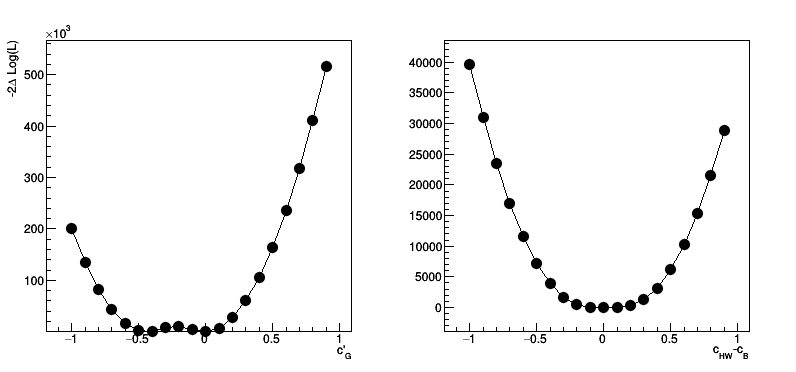

In [17]:
gr_cG1.GetYaxis().SetTitle("-2#Delta Log(L)") 
gr_cG1.GetXaxis().SetTitle("c'_{G}") 
gr_cG1.SetMarkerStyle(20)


gr_cHWmB.GetYaxis().SetTitle("-2#Delta Log(L)") 
gr_cHWmB.GetXaxis().SetTitle("c_{HW}-c_{B}") 
gr_cHWmB.SetMarkerStyle(20)

c_1D = ROOT.TCanvas("LH1D","LH1D",800,400)
c_1D.Divide(2)
c_1D.cd(1)
gr_cG1.Draw("ALP")
c_1D.cd(2)
gr_cHWmB.Draw("ALP")
c_1D.Draw()

You can see there is a double minimum in the $c'_{G}$ which should be accounted for in the 1D confidence intervals. 

We can look at how the uncertainty on $c_{HW}-c_{B}$ looks like if we fix $c'_{G}$ to 0. If we had stronger correlations, do you think it would make more of a difference?

In [18]:
## assuming cG1=0
eft[0].setVal(0.)
eft[0].setConstant()
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.WARNING)
ROOT.RooMsgService.instance().setSilentMode(True);

eftPdf.fitTo(combData,ROOT.RooFit.Minos(),ROOT.RooFit.PrintEvalErrors(-1) )
print "-------- FIT 1 ---------"
print eft[1].GetName(),eft[1].getVal(), "+/-",eft[1].getAsymErrorLo(),eft[1].getAsymErrorHi()
print eft[0].GetName(),eft[0].getVal(), "+/-",eft[0].getAsymErrorLo(),eft[0].getAsymErrorHi()
print "-------- FIT 2 ---------"
eft[0].setVal(0.)
eft[0].setConstant(False)
eft[1].setVal(0.)
eft[1].setConstant(True)

eftPdf.fitTo(combData,ROOT.RooFit.Minos(),ROOT.RooFit.PrintEvalErrors(-1) )
print eft[0].GetName(),eft[0].getVal(), "+/-",eft[0].getAsymErrorLo(),eft[0].getAsymErrorHi()

# reset
[e.setVal(0.) for e in eft]
[e.setConstant(False) for e in eft]

-------- FIT 1 ---------
cHWmB 0.00911201443643 +/- -0.0381409282346 0.0468077166085
cG1 0.0 +/- 0.0 0.00142206264717
-------- FIT 2 ---------
cG1 -0.00214323954531 +/- -0.00129529052469 0.00129318494938


[None, None]

## Part 3: Covariance matrix propagation

Assuming gaussian error propagation. Model for nuisances and correlation is unprecise.

In [19]:
mes_a=np.array([ ri.getVal() for ri in r ])
err_a=np.array([ ri.getError()  for ri in r])
cor_a=np.array(
    [
     [ cor.GetBinContent(i+1,j+1) for i in range(0,len(r)) ] for j in range(0,len(r))  
    ]
)
cov_a=np.multiply(err_a[:,np.newaxis],np.multiply(cor_a,err_a))
icov_a = np.linalg.inv(cov_a) # inverse of the covariance matrix

import math
print mes_a
print cov_a
print [math.sqrt(cov_a[i,i]) for i in range(0,len(mes_a))]

[ 0.98174738  1.00047124  0.90288444]
[[  1.26137932e-04  -3.50345308e-05  -8.35948767e-05]
 [ -3.50345308e-05   2.16882841e-03   1.42531245e-05]
 [ -8.35948767e-05   1.42531245e-05   2.09196625e-02]]
[0.011231114466467462, 0.0465706818415601, 0.14463631125938925]


In [20]:
# test broadcasting
a = np.array([ [1,0.0001],[1000.,10]])
b = np.array([2,3])
np.multiply(b[:,np.newaxis],np.multiply(a,b))

array([[  4.00000000e+00,   6.00000000e-04],
       [  6.00000000e+03,   9.00000000e+01]])

In [21]:
from scipy.optimize import minimize
def chi2_cG(p):
    global mes_a,icov_a
    ##pars[0] = cG1
    sc=np.array([
        1.+p[0]*(8.73+19.5*p[0]),
        1.,
        1.+0.115*p[0]+0.0297*p[0]**2
    ])
    return np.dot(mes_a-sc,np.dot(icov_a,mes_a-sc))
#minimize
cG0=np.array([0.])
rbf=minimize(chi2_cG,cG0,
            method='SLSQP',
            jac=False);
print rbf.x ## strength modifiers.

[-0.00214529]


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.xlabel('cG1')
plt.ylabel('chi2')
#ax = plt.axes()
cG_l=np.arange(-.006,-.0,0.0001)# start, stop, step
chi2_l=np.array([chi2_cG(np.array([s])) for s in cG_l]).flatten()
plt.plot (cG_l, chi2_l-rbf.fun,color='lightskyblue',label="chi2")
plt.legend()
plt.show()